# IMEDIA Project



> **Estado**: MVP funcional (Reddit) · Arquitectura escalable a Facebook/Threads/X · Medallion (`raw → bronze → silver → gold`)

---

## 1) Introducción
En un entorno donde la información cambia a velocidad absurda, **IMEDIA Project** nace para ayudarte a **explorar, analizar y entender** lo que pasa en redes sociales y comunidades online. Empezamos por **Reddit** (API abierta, estable), pero la arquitectura ya está pensada para sumar **Facebook, Threads, X (Twitter)** u otras fuentes.

IMEDIA implementa un pipeline de datos reproducible (con **uv**, **Polars**, **SQLite**) que extrae publicaciones/comentarios, los procesa por capas (**medallion**), y deja la puerta abierta a **NLP** y **dashboards**.

---

## 2) Problema y justificación
- Las personas y equipos necesitan **monitorizar tendencias**, **temas** y **sentimientos** sin perderse en scroll infinito.
- Las APIs y formatos cambian; necesitas una **arquitectura modular**, **idempotente** y **trazable**.
- Herramientas low-code/BI ayudan a visualizar, pero el valor nace en **datos limpios** y **modelados**.

**IMEDIA** justifica su existencia al: (1) estandarizar ingestion y almacenamiento, (2) dejar un **track** auditable por capas, (3) facilitar análisis avanzados (NLP, LLMs, dashboards) sobre bases sólidas.

---

## 3) Objetivos
**General**: Automatizar la **recolección y procesamiento** de contenido social para habilitar análisis y visualizaciones confiables.

**Específicos**:
- Ingerir contenido de Reddit vía API oficial (PRAW).
- Normalizar y persistir en formato analítico (**Parquet**) y en una base **SQLite** para consultas rápidas.
- Preparar **dimensiones** y **hechos** (SILVER) que soporten KPIs y análisis posteriores.
- Diseñar una CLI reproducible con **uv** para orquestar corridas.
- Roadmap: sentiment/topic modeling, features para LLMs, dashboards (Power BI/DuckDB, etc.).

---

## 4) Alcance (MVP) y estado actual
- **Fuente**: Reddit ✅
- **Pipeline**: `raw → bronze → silver` ✅ (gold en diseño)
- **Persistencia**: Parquet + SQLite ✅
- **CLI**: modo *subreddit único* y modo *descubrimiento de N subreddits “hot”* ✅
- **Comentarios**: descarga del **primer post** por subreddit (flag `--fetch-comments`) ✅
- **GOLD**: KPIs/ML/LLMs (pendiente) 🔜

---

## 5) Arquitectura del pipeline (Medallion)
```
Reddit API → [RAW] NDJSON (as-is) → [BRONZE] Parquet (tipado/flatten) → [SILVER] Parquet+SQLite (dims/facts) → [GOLD] KPIs/Features/LLMs
```
**Capas**:
- **RAW**: dumps sin transformar (NDJSON por origen/lote). No se borra ni se pisa.
- **BRONZE**: tipado suave, separar campos, **sin perder columnas** (nulos permitidos). Particionado por fecha (`created_utc`).
- **SILVER**: normalización (dimensiones y tablas de hechos), claves coherentes, **upsert** en SQLite.
- **GOLD**: métricas, agregados, features ML y vistas para BI (en construcción).

**Modelado (SILVER)**:
- `dim_subreddit(subreddit, subscribers, description, created_utc, over18)`
- `dim_author(author_name)`
- `fact_posts(post_id, subreddit, author, title, selftext, url, score, num_comments, over_18, created_utc, …)`
- `fact_comments(comment_id, post_id, author, body, created_utc, score, …)`

---

## 6) Estructura del repositorio
```
imedia/
├─ pyproject.toml
├─ .env.example
├─ README.md
├─ db/
│  └─ imedia.sqlite
└─ data/
   ├─ raw/reddit/
   │  ├─ posts/part-<batch>-[subreddit].ndjson
   │  ├─ comments/part-<batch>-[post_id].ndjson
   │  ├─ subreddits/part-<batch>-[subreddit].ndjson
   │  └─ hot_sublists/part-<batch>-<estrategia>.ndjson
   ├─ bronze/reddit/
   │  ├─ posts/YYY=…/MM=…/DD=…/posts__<batch>__<subreddit>.parquet
   │  ├─ comments/YYY=…/MM=…/DD=…/comments__<batch>__<post_id>.parquet
   │  ├─ subreddits/subreddits-<batch>-<subreddit>.parquet
   │  └─ hot_sublists/hot_sublists-<batch>-<uid>.parquet
   └─ silver/reddit/
      ├─ dim_subreddit.parquet
      ├─ dim_author.parquet
      ├─ fact_posts.parquet
      └─ fact_comments.parquet
```

### Código fuente (src/)
- `config.py` — rutas, batch id, env vars
- `reddit_client.py` — autenticación PRAW (read-only)
- `raw_extractor.py` — descarga **as-is** a RAW
- `bronze_transformer.py` — tipado/flatten → BRONZE
- `silver_normalizer.py` — normalización + upsert a SQLite
- `gold_products.py` — placeholder para KPIs/ML
- `repo_sqlite.py` — DDL + upserts
- `utils.py` — helpers (slugify, casts robustos)
- `__main__.py` — CLI orquestador

---

## 7) Requisitos
- **Python** ≥ 3.11
- **uv** (gestión de entornos ultra-rápida) → https://docs.astral.sh/uv/
- Conexión a internet (para API Reddit)

---

## 8) Instalación
```bash
# 1) clona el repo
git clone <URL-del-repo>
cd imedia

# 2) instala dependencias
uv sync

# 3) copia variables de entorno
type .env.example > .env   # (Windows: cp .env.example .env)
```

### Variables de entorno (`.env`)
```env
REDDIT_CLIENT_ID=tu_client_id
REDDIT_CLIENT_SECRET=tu_client_secret
REDDIT_USER_AGENT=imedia/0.1 by <tu_usuario>
IMEDIA_DB_PATH=db/imedia.sqlite
IMEDIA_DATA_ROOT=data
REDDIT_REQUEST_TIMEOUT=30
# opcional para etiquetar corridas manualmente
# IMEDIA_BATCH_TS=20250101_1200
```

### Test de autenticación
```bash
uv run python -c "from imedia.reddit_client import RedditClient; r=RedditClient().reddit; s=r.subreddit('python'); print('OK Reddit! subs:', getattr(s,'subscribers',None))"
```

---

## 9) Uso (CLI)
La CLI vive en `__main__.py`. Ejecuta con `uv run python -m imedia [opciones]`.

### Modos (exclusivos)
1. **Subreddit único**
```bash
uv run python -m imedia \
  --subreddit python \
  --limit 50 \
  --time-filter day \
  --fetch-comments
```
2. **Descubrir N subreddits “hot”** (y descargar posts de cada uno)
```bash
uv run python -m imedia \
  --discover-hot 10 \
  --hot-strategy all_top_day \
  --limit 30 \
  --include-nsfw    # opcional
```

### Parámetros
| Parámetro | Tipo | Obligatorio | Default | Descripción |
|---|---:|:---:|---:|---|
| `--subreddit <nombre>` | str | **Mutuamente excluyente** con `--discover-hot` | — | Modo 1: ingestión de un subreddit específico. |
| `--discover-hot <N>` | int | **Mutuamente excluyente** con `--subreddit` | — | Modo 2: descubre N subreddits “calientes” y descarga posts de cada uno. |
| `--hot-strategy {popular,all_hot,all_top_day}` | str | No (solo aplica con `--discover-hot`) | `popular` | Cómo descubrir subreddits: `popular` (rápido), `all_hot` (zeitgeist), `all_top_day` (mejores del día). |
| `--include-nsfw` | flag | No | `false` | Incluir subreddits NSFW en el descubrimiento. |
| `--limit <N>` | int | No | `100` | Posts a descargar **por subreddit**. |
| `--time-filter {hour,day,week,month,year,all}` | str | No | `day` | Ventana temporal para `top`. |
| `--fetch-comments` | flag | No | `false` | Descarga comentarios del **primer post** en cada subreddit del lote. |

> **Nota**: `--fetch-comments` actualmente trae **solo** el primer post de cada subreddit. Un flag `--all-comments` puede añadirse en el roadmap.

### Ejemplos útiles
- Top 20 `machinelearning` última semana con comentarios del primer post:
```bash
uv run python -m imedia --subreddit machinelearning --limit 20 --time-filter week --fetch-comments
```
- Descubrir 15 subreddits por popularidad e ingerir 40 posts por cada uno:
```bash
uv run python -m imedia --discover-hot 15 --hot-strategy popular --limit 40
```

---

## 10) Salidas esperadas
- **RAW**: NDJSON por origen (no se pisa). Ej: `data/raw/reddit/posts/part-<batch>-python.ndjson`.
- **BRONZE**: Parquet particionado por `YYYY/MM/DD` (posts/comments) + archivos únicos por sub/post.
- **SILVER**: `dim_*.parquet`, `fact_*.parquet` y **SQLite** poblado (`db/imedia.sqlite`).

---

## 11) Verificación rápida (post-run)
```bash
# conteos en SQLite
uv run python - <<'PY'
import sqlite3
con = sqlite3.connect('db/imedia.sqlite')
for t in ('subreddits','authors','posts','comments'):
    try:
        n = con.execute(f'SELECT count(*) FROM {t}').fetchone()[0]
        print(t, n)
    except Exception as e:
        print(t, 'no existe:', e)
PY
```
```bash
# inspeccionar SILVER
uv run python - <<'PY'
import polars as pl
p = pl.read_parquet('data/silver/reddit/fact_posts.parquet')
print('subs distintos:', p.select('subreddit').n_unique())
print('total posts:', p.height)
print(p.select('subreddit').unique().head(15))
PY
```

---

## 12) Solución de problemas comunes
- **`ValueError: Faltan variables en .env`** → Completa `REDDIT_CLIENT_ID/SECRET/USER_AGENT`.
- **`OAuthException`** (PRAW) → Verifica que tu app de Reddit sea de tipo **script** y que el secret sea correcto.
- **Timeouts** → Aumenta `REDDIT_REQUEST_TIMEOUT` (ej. 60) o reduce `--limit` y la cantidad de subreddits.

---

## 13) Roadmap (sujeto a cambios)
- `--all-comments` (comentarios de todos los posts del lote)
- Capa **GOLD**: KPIs (7d/24h), engagement por hora, features para modelos
- Integración **LLMs**: Q&A sobre corpus, resúmenes temáticos
- Más fuentes: X/Threads/Facebook (cuando políticas y APIs lo permitan)
- Export a **DuckDB/ADBC** y/o formatos **Delta/Iceberg** para datasets grandes
- Tests `pytest` + `ruff` 



# EDA

In [1]:
import sqlite3
import pandas as pd

# Ruta a tu base de datos
db_path = "../db/imedia.sqlite"

# Conectar a la base de datos
conn = sqlite3.connect(db_path)

# Mostrar las tablas disponibles
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
print("Tablas disponibles:")
print(tables)

# Leer los datos de cada tabla
authors = pd.read_sql_query("SELECT * FROM authors;", conn)
comments = pd.read_sql_query("SELECT * FROM comments;", conn)
posts = pd.read_sql_query("SELECT * FROM posts;", conn)
subreddits = pd.read_sql_query("SELECT * FROM subreddits;", conn)

# Visualizar primeras filas de cada tabla
print("\n=== Tabla: authors ===")
display(authors.head())

print("\n=== Tabla: comments ===")
display(comments.head())

print("\n=== Tabla: posts ===")
display(posts.head())

print("\n=== Tabla: subreddits ===")
display(subreddits.head())

# Cerrar la conexión
conn.close()


Tablas disponibles:
         name
0  subreddits
1     authors
2       posts
3    comments

=== Tabla: authors ===


,author_name
0,Typical_Wafer_1324
1,krobzaur
2,ITagEveryone
3,ditlevrisdahl
4,geovane_jeff



=== Tabla: comments ===


,comment_id,post_id,author,body,created_utc,parent_id,link_id,score,is_submitter
0,ng4q0es,1nq1588,Present_Tonight1813,I made a program that prompts the user for a s...,1.758810e+09,t3_1nq1588,t3_1nq1588,2,0
1,ng4cg2y,1nq1588,cptsdemon,I made a tool called [PyLiveDev](https://pypi....,1.758805e+09,t3_1nq1588,t3_1nq1588,2,0
2,ng6dq2g,1nq1588,Fr1dge21,As my first project I managed to automate stoc...,1.758827e+09,t3_1nq1588,t3_1nq1588,4,0
3,ng8r3e5,1nq1588,AdventPriest,"Full disclosure, I've leaned heavily on AI to ...",1.758856e+09,t1_ng4aj2a,t3_1nq1588,1,0
4,ng5ys9z,1nq1588,geovane_jeff,My own backup app :D saves me every week!,1.758822e+09,t3_1nq1588,t3_1nq1588,4,0



=== Tabla: posts ===


,post_id,title,selftext,url,permalink,score,num_comments,over_18,created_utc,link_flair_text,is_self,spoiler,locked,thumbnail,subreddit,author
0,1nqnm44,PEP 806 – Mixed sync/async context managers wi...,PEP 806 – Mixed sync/async context managers wi...,https://www.reddit.com/r/Python/comments/1nqnm...,/r/Python/comments/1nqnm44/pep_806_mixed_synca...,107,19,0,1.758847e+09,News,1,0,0,self,PYTHON,kirara0048
1,1nqfyqh,Looking for Feedback and suggestions: Soundmen...,[Soundmentations](https://github.com/saumyarr8...,https://www.reddit.com/r/Python/comments/1nqfy...,/r/Python/comments/1nqfyqh/looking_for_feedbac...,3,0,0,1.758828e+09,Discussion,1,0,0,self,PYTHON,saumyarr8
2,1nq45ep,migrating from django to FastAPI,We've hit the scaling wall with our decade-old...,https://www.reddit.com/r/Python/comments/1nq45...,/r/Python/comments/1nq45ep/migrating_from_djan...,19,53,0,1.758800e+09,Discussion,1,0,0,self,PYTHON,No-Excitement-7974
3,1nq1588,What small Python automation projects turned o...,I’m trying to level up through practice and I’...,https://www.reddit.com/r/Python/comments/1nq15...,/r/Python/comments/1nq1588/what_small_python_a...,141,87,0,1.758788e+09,Discussion,1,0,0,self,PYTHON,MENTX3
4,1nq5x1b,PyCon AU 2025 talks are all up!,This year's PyCon AU talks have all been uploa...,https://www.reddit.com/r/Python/comments/1nq5x...,/r/Python/comments/1nq5x1b/pycon_au_2025_talks...,19,1,0,1.758805e+09,Resource,1,0,0,self,PYTHON,fphhotchips



=== Tabla: subreddits ===


,subreddit,subscribers,description,created_utc,over18
0,PYTHON,1396681,The official Python community for Reddit! Stay...,1.201231e+09,0
1,FUNNY,66782305,Reddit's largest humor depository,1.201243e+09,0
2,PUBLICFREAKOUT,4721897,"A subreddit dedicated to people freaking out, ...",1.381610e+09,0
3,ASKREDDIT,57060610,r/AskReddit is the place to ask and answer tho...,1.201233e+09,0
4,BALDURSGATE3,3214587,"A community all about Baldur's Gate III, the r...",1.559227e+09,0


In [2]:
with sqlite3.connect(db_path) as conn:
    # 1) Tablas disponibles (excluye internas)
    tables = pd.read_sql_query(
        "SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite_%';",
        conn
    )
    table_list = tables['name'].tolist()
    print("Tablas encontradas:", table_list, "\n")

    # 2) EDA básico por tabla
    for t in table_list:
        df = pd.read_sql_query(f"SELECT * FROM {t};", conn)

        print(f"\n=== Tabla: {t} ===")
        print("Shape:", df.shape)

        # Tipos y nulos
        print("\nTipos de datos:")
        print(df.dtypes)

        print("\nValores nulos (top 10):")
        print(df.isna().sum().sort_values(ascending=False).head(10))

        # Estadísticas numéricas
        num = df.select_dtypes(include='number')
        if not num.empty:
            print("\nEstadísticas descriptivas (numéricas):")
            print(num.describe().T)

        # Resumen categórico: top 10 valores de hasta 3 columnas
        cat = df.select_dtypes(include='object')
        if not cat.empty:
            cols = list(cat.columns[:3])  # limita para no saturar la salida
            for col in cols:
                print(f"\nTop 10 valores en '{col}':")
                print(cat[col].value_counts(dropna=False).head(10))
        print("="*70)

Tablas encontradas: ['subreddits', 'authors', 'posts', 'comments'] 


=== Tabla: subreddits ===
Shape: (13, 5)

Tipos de datos:
subreddit       object
subscribers      int64
description     object
created_utc    float64
over18           int64
dtype: object

Valores nulos (top 10):
subreddit      0
subscribers    0
description    0
created_utc    0
over18         0
dtype: int64

Estadísticas descriptivas (numéricas):
             count          mean           std           min           25%  \
subscribers   13.0  1.707297e+07  2.203671e+07  3.544890e+05  3.214587e+06   
created_utc   13.0  1.325286e+09  1.446797e+08  1.201221e+09  1.201243e+09   
over18        13.0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

                      50%           75%           max  
subscribers  6.589294e+06  1.990339e+07  6.678230e+07  
created_utc  1.251449e+09  1.381610e+09  1.622896e+09  
over18       0.000000e+00  0.000000e+00  0.000000e+00  

Top 10 valores en 'subreddit':
subreddit
P

# 🧩 Análisis Exploratorio de Datos (EDA)

El conjunto de datos proviene de la base `imedia.sqlite`, con información de Reddit.  
Contiene 4 tablas principales: **subreddits**, **authors**, **posts** y **comments**.

---

## **1. subreddits**
- 13 registros × 5 columnas.
- Sin valores nulos.
- Subreddits variados: `PYTHON`, `ASKREDDIT`, `FUNNY`, etc.
- Promedio de **17M suscriptores** (σ ≈ 22M).
- Ninguno marcado como contenido adulto (`over18 = 0`).

📍 **Conclusión:**  
Se observan comunidades grandes y heterogéneas. `subscribers` puede indicar el alcance o tamaño de la audiencia.

---

## **2. authors**
- 350 autores únicos, sin valores nulos.
- Cada autor aparece una sola vez.

📍 **Conclusión:**  
Sirve para analizar actividad por usuario o enriquecer el modelo con métricas de participación.

---

## **3. posts**
- 279 publicaciones × 16 columnas.
- Variable objetivo candidata: `score` (promedio ≈ 2977, σ ≈ 7032).
- `num_comments` promedio ≈ 301, con alto rango (hasta 6411).
- 30% son publicaciones de texto (`is_self=1`).
- `over_18` solo 2%, `spoiler` casi nulo.
- Faltan valores en `link_flair_text` (~55%).

📍 **Conclusión:**  
Distribución con outliers, útil aplicar normalización logarítmica.  
Variables `subreddit`, `is_self`, `created_utc` y `num_comments` relevantes para modelado.

---

## **4. comments**
- 103 registros × 9 columnas.
- Sin valores nulos.
- Solo 2 publicaciones concentran todos los comentarios.
- `score` promedio ≈ 6.3, máximo 101.

📍 **Conclusión:**  
Datos desbalanceados: conviene muestrear o normalizar por `post_id`.

---

## **5. Relaciones clave**
- `posts.subreddit` ↔ `subreddits.subreddit`
- `posts.author` ↔ `authors.author_name`
- `comments.post_id` ↔ `posts.post_id`

📊 **Conclusión global:**
- Datos limpios, pero con fuerte dispersión y sesgos de actividad.  
- `score` o `num_comments` pueden ser variables objetivo.  
- Conviene explorar gráficamente la distribución y correlaciones.

---


In [3]:
# === EDA Genérico con funciones (solo matplotlib) ===
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Optional

# ---------------------------
# Carga de datos (genérica)
# ---------------------------
def load_sqlite_tables(db_path: str, exclude_internal: bool = True) -> Dict[str, pd.DataFrame]:
    """Carga todas las tablas de una base SQLite en un dict {tabla: DataFrame}."""
    with sqlite3.connect(db_path) as conn:
        query = "SELECT name FROM sqlite_master WHERE type='table'"
        if exclude_internal:
            query += " AND name NOT LIKE 'sqlite_%'"
        tables = pd.read_sql_query(query + ";", conn)['name'].tolist()
        dfs = {t: pd.read_sql_query(f"SELECT * FROM {t};", conn) for t in tables}
    return dfs

# ---------------------------
# Utilidades de columnas
# ---------------------------
def numeric_cols(df: pd.DataFrame) -> List[str]:
    return df.select_dtypes(include=[np.number]).columns.tolist()

def categorical_cols(df: pd.DataFrame, max_unique: int = 50) -> List[str]:
    cats = df.select_dtypes(include=["object", "category"]).columns
    return [c for c in cats if df[c].nunique(dropna=False) <= max_unique]

def ensure_datetime(series: pd.Series) -> pd.Series:
    """Convierte epoch (s o ms) o texto a datetime si es posible."""
    s = series.copy()
    if np.issubdtype(s.dtype, np.number):
        # Heurística: si valores grandes (ms) divide entre 1000
        median = np.nanmedian(s)
        if median > 1e12:
            s = pd.to_datetime(s/1000, unit="s", errors="coerce", utc=True)
        else:
            s = pd.to_datetime(s, unit="s", errors="coerce", utc=True)
    else:
        s = pd.to_datetime(s, errors="coerce", utc=True)
    return s

# ---------------------------
# Funciones de gráficos
# (cada una crea su propia figura)
# ---------------------------
def plot_distribution(df: pd.DataFrame, col: str, bins: int = 30, log: bool = False, title: Optional[str] = None):
    if col not in df.columns:
        print(f"[skip] '{col}' no existe en DataFrame.")
        return
    x = df[col].dropna()
    if x.empty:
        print(f"[skip] '{col}' no tiene datos.")
        return
    plt.figure()
    # Si log=True, graficamos el hist de log1p para evitar valores <=0
    data = np.log1p(x) if log else x
    plt.hist(data, bins=bins)
    plt.xlabel(f"{col}" + (" (log1p)" if log else ""))
    plt.ylabel("Frecuencia")
    plt.title(title or f"Distribución de {col}" + (" (log1p)" if log else ""))
    plt.tight_layout()
    plt.show()

def plot_scatter(df: pd.DataFrame, xcol: str, ycol: str, title: Optional[str] = None, alpha: float = 0.7):
    for c in (xcol, ycol):
        if c not in df.columns:
            print(f"[skip] '{c}' no existe en DataFrame.")
            return
    x = df[xcol]
    y = df[ycol]
    m = (~x.isna()) & (~y.isna())
    if m.sum() == 0:
        print(f"[skip] No hay datos válidos para {xcol} vs {ycol}.")
        return
    plt.figure()
    plt.scatter(x[m], y[m], alpha=alpha)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    plt.title(title or f"{ycol} vs {xcol}")
    plt.tight_layout()
    plt.show()

def bar_mean_by_category(df: pd.DataFrame, cat_col: str, val_col: str, top_n: int = 20, title: Optional[str] = None):
    for c in (cat_col, val_col):
        if c not in df.columns:
            print(f"[skip] '{c}' no existe en DataFrame.")
            return
    tmp = df[[cat_col, val_col]].dropna()
    if tmp.empty:
        print(f"[skip] No hay datos para {cat_col} y {val_col}.")
        return
    g = tmp.groupby(cat_col, dropna=False)[val_col].mean().sort_values(ascending=False).head(top_n)
    plt.figure(figsize=(10, max(4, 0.35 * len(g))))
    plt.barh(g.index.astype(str), g.values)
    plt.gca().invert_yaxis()
    plt.xlabel(f"Media de {val_col}")
    plt.ylabel(cat_col)
    plt.title(title or f"Media de {val_col} por {cat_col} (Top {len(g)})")
    plt.tight_layout()
    plt.show()

def bar_count_by_category(df: pd.DataFrame, cat_col: str, top_n: int = 20, title: Optional[str] = None):
    if cat_col not in df.columns:
        print(f"[skip] '{cat_col}' no existe en DataFrame.")
        return
    s = df[cat_col].astype(str).value_counts().head(top_n)
    if s.empty:
        print(f"[skip] '{cat_col}' no tiene conteos.")
        return
    plt.figure(figsize=(10, max(4, 0.35 * len(s))))
    plt.barh(s.index, s.values)
    plt.gca().invert_yaxis()
    plt.xlabel("Cantidad")
    plt.ylabel(cat_col)
    plt.title(title or f"Conteo por {cat_col} (Top {len(s)})")
    plt.tight_layout()
    plt.show()

def plot_time_activity(df: pd.DataFrame, time_col: str, freq: str = "H", title: Optional[str] = None):
    """Serie temporal agregada por frecuencia (H/D/W/M)."""
    if time_col not in df.columns:
        print(f"[skip] '{time_col}' no existe en DataFrame.")
        return
    t = ensure_datetime(df[time_col])
    s = pd.Series(1, index=t)
    s = s.dropna()
    if s.empty:
        print(f"[skip] No hay timestamps válidos en '{time_col}'.")
        return
    agg = s.resample(freq).sum()
    plt.figure()
    plt.plot(agg.index.to_pydatetime(), agg.values)
    plt.xlabel("Tiempo")
    plt.ylabel(f"Eventos por {freq}")
    plt.title(title or f"Actividad temporal basada en {time_col} ({freq})")
    plt.tight_layout()
    plt.show()

# ---------------------------
# Orquestador (seguro a cambios)
# ---------------------------
def run_generic_eda_plots(
    tables: Dict[str, pd.DataFrame],
    posts_name: str = "posts",
    comments_name: str = "comments",
    subreddits_name: str = "subreddits",
):
    """
    Ejecuta gráficos clave si las columnas existen.
    Diseñado para datasets que pueden cambiar.
    """
    posts = tables.get(posts_name)
    comments = tables.get(comments_name)
    subreddits = tables.get(subreddits_name)

    # --- Distribuciones en posts ---
    if isinstance(posts, pd.DataFrame):
        if "score" in posts.columns:
            plot_distribution(posts, "score", bins=40, log=False, title="Distribución de Score")
            plot_distribution(posts, "score", bins=40, log=True, title="Distribución de Score (log1p)")
        if "num_comments" in posts.columns:
            plot_distribution(posts, "num_comments", bins=40, log=False, title="Distribución de Número de Comentarios")

        # --- Relación score vs num_comments ---
        if {"score", "num_comments"} <= set(posts.columns):
            plot_scatter(posts, "num_comments", "score", title="Score vs Número de Comentarios")

        # --- Score promedio por subreddit ---
        if {"subreddit", "score"} <= set(posts.columns):
            bar_mean_by_category(posts, "subreddit", "score", top_n=20, title="Score promedio por Subreddit")

        # --- Conteo de posts por subreddit ---
        if "subreddit" in posts.columns:
            bar_count_by_category(posts, "subreddit", top_n=20, title="Cantidad de Posts por Subreddit")

        # --- Actividad temporal de posts ---
        for tc in ["created_utc", "created_at", "created"]:
            if tc in posts.columns:
                plot_time_activity(posts, tc, freq="H", title=f"Actividad temporal de Posts ({tc}, H)")
                break

    # --- Comentarios (si aplica) ---
    if isinstance(comments, pd.DataFrame):
        if "score" in comments.columns:
            plot_distribution(comments, "score", bins=40, log=False, title="Distribución de Score (Comentarios)")
        for tc in ["created_utc", "created_at", "created"]:
            if tc in comments.columns:
                plot_time_activity(comments, tc, freq="H", title=f"Actividad temporal de Comentarios ({tc}, H)")
                break
        # Conteo por post_id para ver concentración de comentarios
        if "post_id" in comments.columns:
            bar_count_by_category(comments, "post_id", top_n=15, title="Comentarios por Post (Top 15)")

    # --- Subreddits (si aplica) ---
    if isinstance(subreddits, pd.DataFrame):
        # Distribución de suscriptores y top por suscriptores
        if "subscribers" in subreddits.columns:
            plot_distribution(subreddits, "subscribers", bins=30, log=True, title="Distribución de Suscriptores (log1p)")
        if {"subreddit", "subscribers"} <= set(subreddits.columns):
            bar_mean_by_category(subreddits, "subreddit", "subscribers", top_n=20, title="Suscriptores por Subreddit (Top)")

# ---------------------------
# Ejemplo de uso rápido
# ---------------------------
# db_path = "db/imedia.sqlite"
# tables = load_sqlite_tables(db_path)
# run_generic_eda_plots(tables)


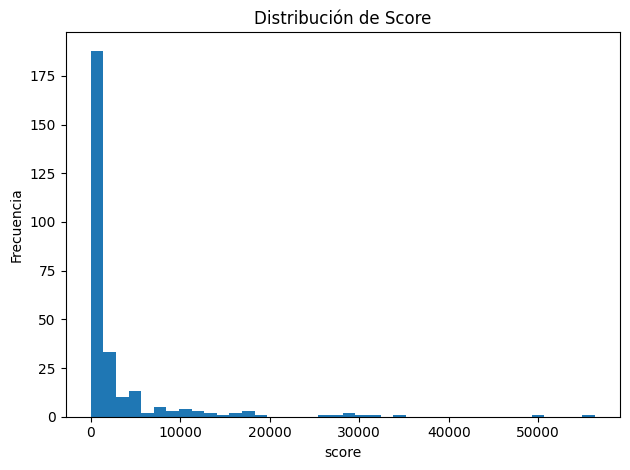

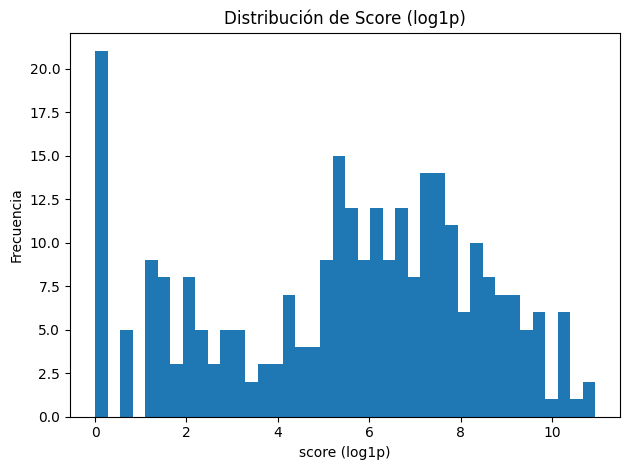

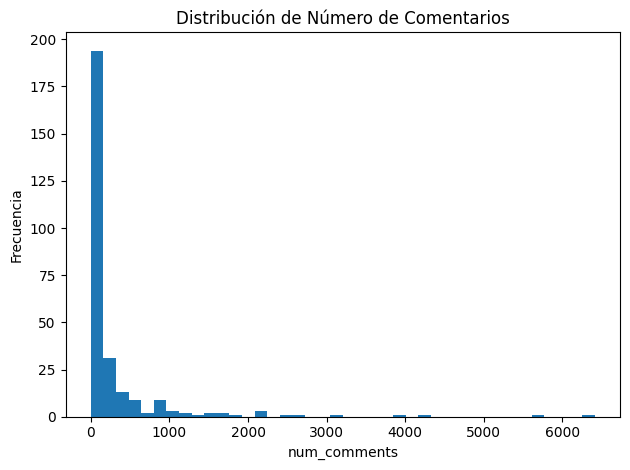

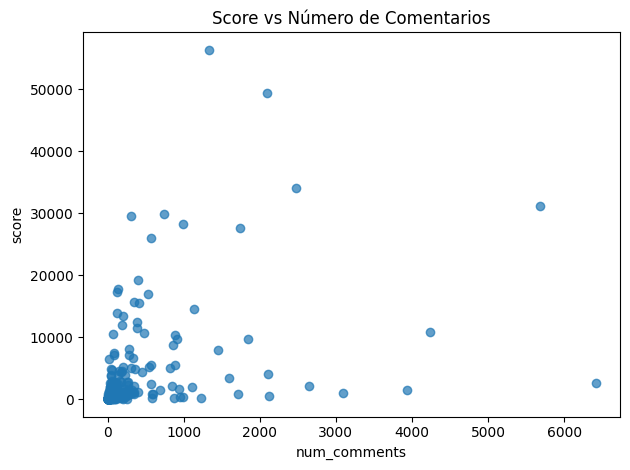

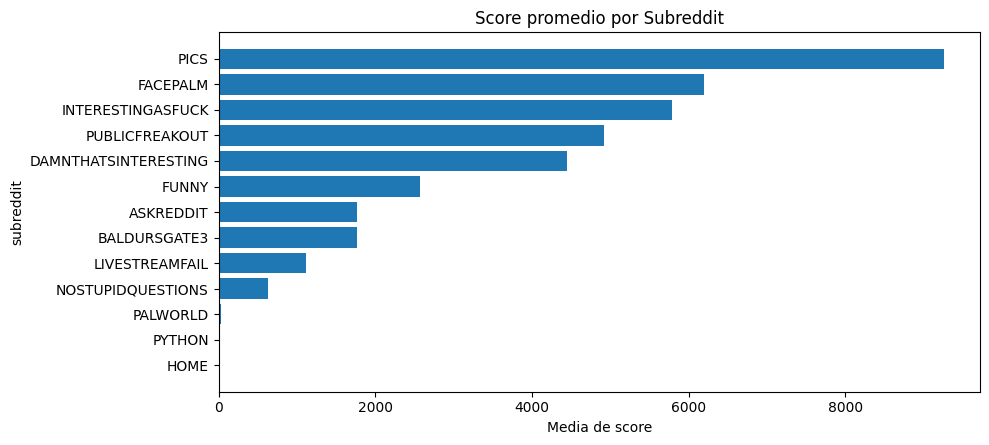

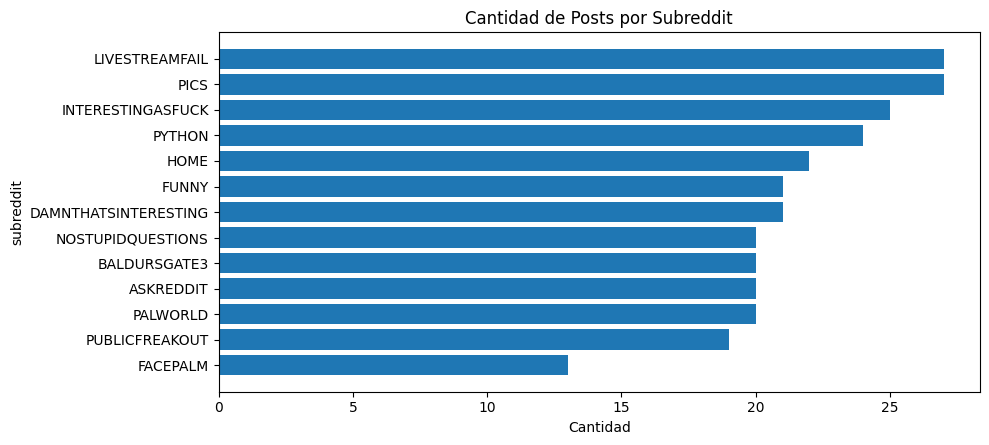

/var/folders/fd/q5kbvbvd00b4rdf_lfzx0j3m0000gp/T/ipykernel_37597/1697844669.py:133: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  agg = s.resample(freq).sum()


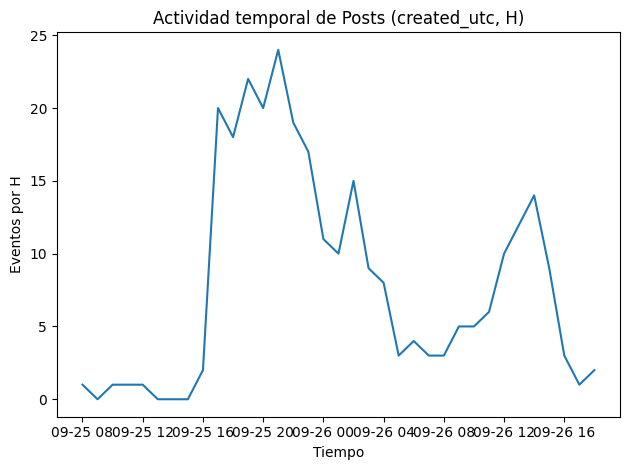

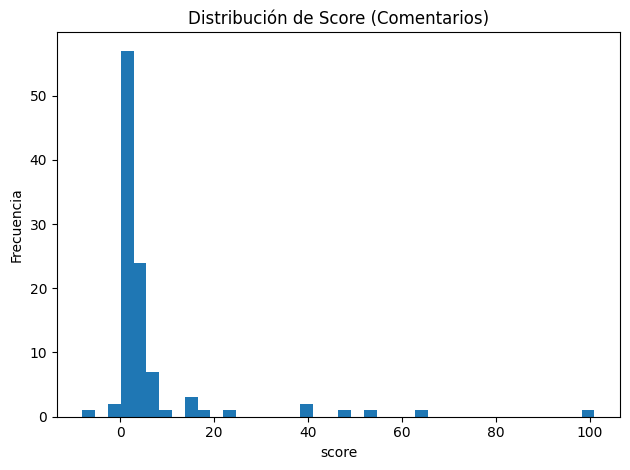

/var/folders/fd/q5kbvbvd00b4rdf_lfzx0j3m0000gp/T/ipykernel_37597/1697844669.py:133: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  agg = s.resample(freq).sum()


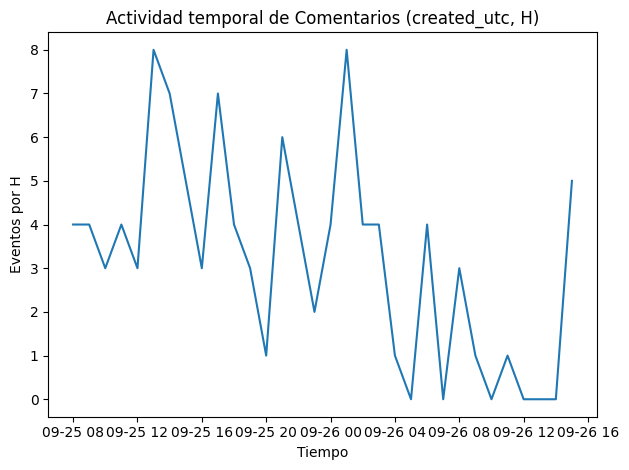

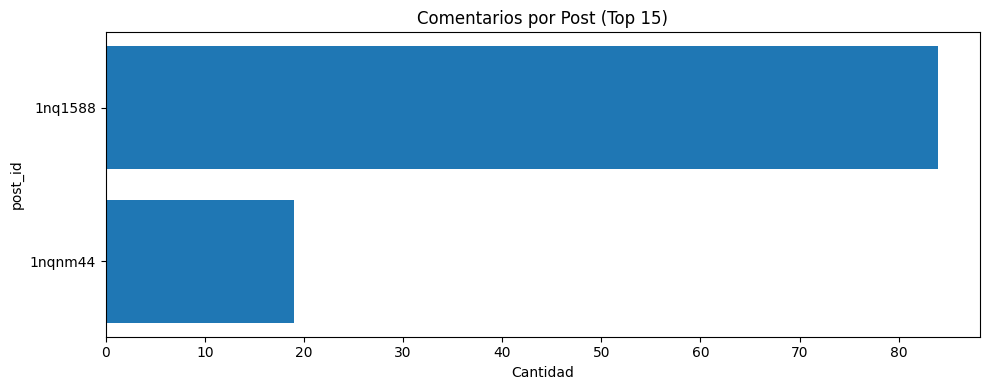

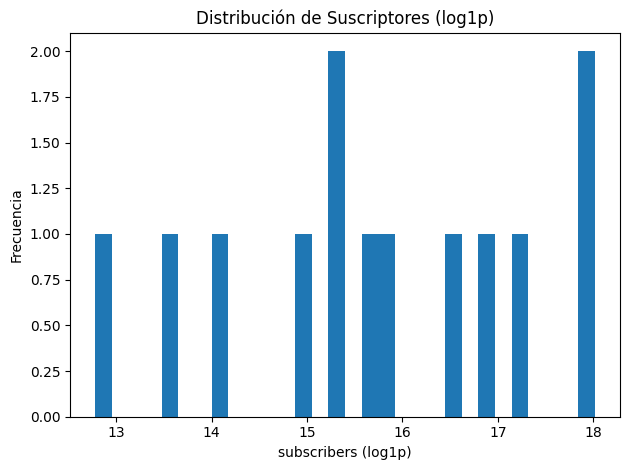

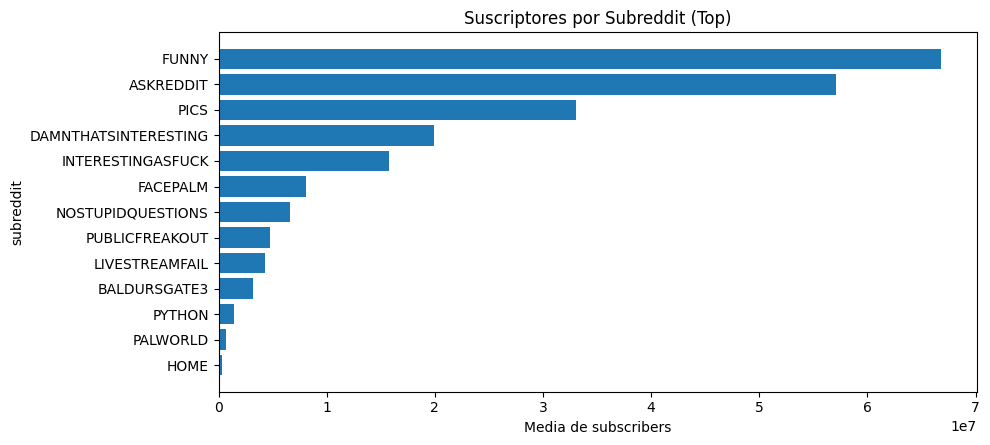

In [4]:
tables = load_sqlite_tables("../db/imedia.sqlite")
run_generic_eda_plots(tables)
